Zachary Armand

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from json import dump
# PyTorch imports
import torch
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
# Local import
from tools import train_model, evaluate_model, best_hyperparameter_results, visualize_all_hyperparameter_results, EarlyStopping
from models import SimpleNet, BaseballRNN

In [2]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [3]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [4]:
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

Dataset and dataloaders are used for both models.

In [5]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, valid_dataset = random_split(train_dataset, [0.89, 0.11])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}, Valid: {len(valid_dataset)}")

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train: 57640, Test: 7195, Valid: 7123


In [6]:
# Convert datasets to tensors for easier manipulation
train_inputs = torch.stack([x[0] for x in train_dataset])
valid_inputs = torch.stack([x[0] for x in valid_dataset])
test_inputs = torch.stack([x[0] for x in test_dataset])

# Check the shape of the inputs to ensure it's 4D (e.g., (num_samples, channels, height, width))
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Valid inputs shape: {valid_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")

# Store the original shape for later reshaping
original_shape = train_inputs.shape[1:]  # (channels, height, width) or whatever your original shape was

# Reshape the inputs to 2D (samples, features) for scaling
train_inputs_reshaped = train_inputs.view(train_inputs.size(0), -1)
valid_inputs_reshaped = valid_inputs.view(valid_inputs.size(0), -1)
test_inputs_reshaped = test_inputs.view(test_inputs.size(0), -1)

# Scale the inputs using StandardScaler (you could also use MinMaxScaler or another scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
train_inputs_scaled = torch.tensor(scaler.fit_transform(train_inputs_reshaped.numpy()), dtype=torch.float32)

# Use the same scaler to transform the validation and test data
valid_inputs_scaled = torch.tensor(scaler.transform(valid_inputs_reshaped.numpy()), dtype=torch.float32)
test_inputs_scaled = torch.tensor(scaler.transform(test_inputs_reshaped.numpy()), dtype=torch.float32)

# Reshape the scaled inputs back to the original shape (samples, channels, height, width)
train_inputs_scaled = train_inputs_scaled.view(train_inputs.size(0), *original_shape)
valid_inputs_scaled = valid_inputs_scaled.view(valid_inputs.size(0), *original_shape)
test_inputs_scaled = test_inputs_scaled.view(test_inputs.size(0), *original_shape)

# Recreate the datasets with the scaled inputs
train_dataset = TensorDataset(train_inputs_scaled, torch.stack([x[1] for x in train_dataset]))
valid_dataset = TensorDataset(valid_inputs_scaled, torch.stack([x[1] for x in valid_dataset]))
test_dataset = TensorDataset(test_inputs_scaled, torch.stack([x[1] for x in test_dataset]))

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train inputs shape: torch.Size([57640, 9, 15])
Valid inputs shape: torch.Size([7123, 9, 15])
Test inputs shape: torch.Size([7195, 9, 15])


# Simple Linear model

### MLP hyperparameter tuning

In [7]:
# Number of random combinations to sample
num_random_combinations = 150  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'mlp_dropout': [0.0, 0.1, 0.25, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'hidden_size': [8, 16, 64, 128, 256],
    'grad_clip': [None, 0.5, 1.0, 2.0]
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, mlp_dropout, weight_decay, hidden_size)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for hidden_size in testing_params['hidden_size']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['mlp_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['hidden_size']),
        random.choice(testing_params['grad_clip'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
mlp_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [8]:
results = {}
num_epochs = 150
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay, hidden_size, grad_clip) in enumerate(pbar):

    # Turn dataset into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Create model
    input_size, seq_len = valid_dataloader.dataset[0][0].shape
    simple_baseball_mlp = SimpleNet(input_size=input_size, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

    # Optimizer and early stopper
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Validation loss
        avg_valid_loss = train_model(simple_baseball_mlp, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log.append(avg_valid_loss)
    
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    
    
    # Save results
    results[i] = [eval_log]

    # Final evaluation
    valid_accuracy = evaluate_model(model=simple_baseball_mlp, dataloader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results[i].append(valid_accuracy)
    results[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}\n l2: {weight_decay}, hidden_size: {hidden_size}, grad_clip: {grad_clip}\n{loss}: {valid_accuracy:.4}')
    # Append training epochs
    results[i].append(epoch+1)


Training Models:  11%|█▏        | 17/150 [11:13<1:27:49, 39.62s/it]


KeyboardInterrupt: 

Evaluate the models, first by lowest RSME. Also visualize results to make sure that they aren't overfitting.

6 best models (index and values):
(3, 0.13532265979612842)
(15, 0.1355180372000569)
(2, 0.1358501726798998)
(1, 0.13600418030635775)
(7, 0.1367197568566539)
(8, 0.1380347869860538)


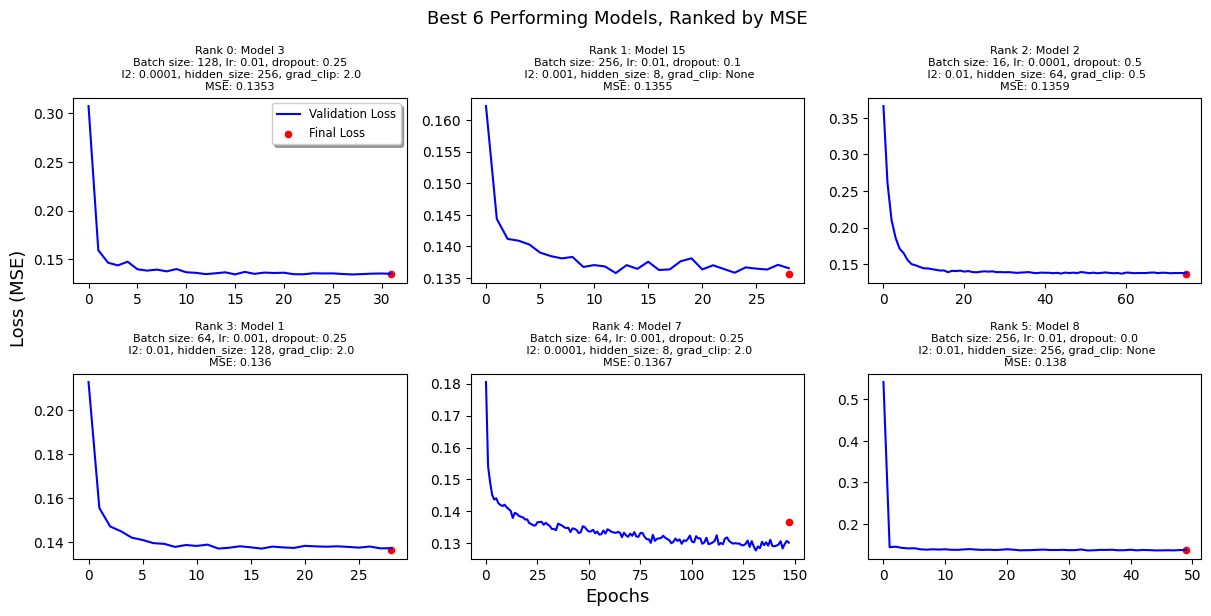

In [9]:
best_hyperparameter_results(results, loss=loss, n_best=6)

In [ ]:
# Save full results to csv
mlp_hyperparam_testing['result_variance'] = [np.var(results[i][0]) for i in results]
mlp_hyperparam_testing['tuning_epochs'] = [results[i][3] for i in results]
mlp_hyperparam_testing[f'tuning_loss_{loss}'] = [results[i][1] for i in results]
mlp_hyperparam_testing.to_csv('./tuning/mlp_hyperparameter_tuning.csv')

In [ ]:
# Determine best hyperparameters based on loss
min_index = mlp_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_mlp_params = mlp_hyperparam_testing.iloc[min_index].to_dict()
print("Best MLP Parameters:")
for key in best_mlp_params:
    print(f"{key}: {best_mlp_params[key]}")

# Write these results to file
with open('./tuning/mlp_best_params.json', 'w') as file:
    best_mlp_params.pop('tuning_loss_MSE', None)
    best_mlp_params.pop('result_variance', None)
    best_mlp_params.pop('tuning_epochs', None)

    dump(best_mlp_params, file, indent=4)

Best MLP Parameters:
batch_size: 256.0
lr: 0.001
mlp_dropout: 0.5
weight_decay: 0.001
hidden_size: 16.0
grad_clip: nan
result_variance: 0.0071409319771806755
tuning_epochs: 111.0
tuning_loss_MSE: 0.1314712852260319


# RNN Network

A many-to-one RNN using gated recurrence units (GRUs)

In [ ]:
# Number of random combinations to sample
num_random_combinations = 150  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'n_layers': [1, 2, 3, 5],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'rnn_dropout': [0.0, 0.1, 0.2, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'grad_clip': [None, 0.5, 1.0, 2.0],
    'hidden_size': [8, 16, 64, 128, 256],
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip)
                      for batch_size in testing_params['batch_size']
                      for n_layers in testing_params['n_layers']
                      for lr in testing_params['lr']
                      for rnn_dropout in testing_params['rnn_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for grad_clip in testing_params['grad_clip']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['n_layers']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['rnn_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['grad_clip']),
        random.choice(testing_params['hidden_size'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
rnn_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [ ]:
results_rnn = {}
num_epochs = 150
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip, hidden_size) in enumerate(pbar):

    # Turn into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Create model
    input_size = valid_dataloader.dataset[0][0].size()[1]
    baseball_rnn = BaseballRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers,
                                hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Optimizer and early stopping
    optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log_rnn = []
    for epoch in range(num_epochs):
        
        # Validation loss
        avg_valid_loss = train_model(baseball_rnn, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log_rnn.append(avg_valid_loss)
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    

    # Save results
    results_rnn[i] = [eval_log_rnn] 

    # Test evaluation
    test_accuracy_rnn = evaluate_model(model=baseball_rnn, dataloader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results_rnn[i].append(test_accuracy_rnn)
    results_rnn[i].append(f'Batch size:{batch_size}, lr:{lr}, n_layers:{n_layers}, dropout:{mlp_dropout}\n l2:{weight_decay}, hidden_size:{hidden_size}, grad_clip:{grad_clip}\n{loss}: {test_accuracy_rnn:.4}')

    # Append training epochs
    results_rnn[i].append(epoch+1)


Training Models:   0%|          | 0/150 [00:00<?, ?it/s]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Training Models:  10%|█         | 15/150 [07:58<1:58:06, 52.49s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Training Models:  13%|█▎        | 19/150 [09:46<55:43, 25.52s/it]  c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater th

6 best models (index and values):
(124, 0.13089989469107693)
(122, 0.131546744209267)
(90, 0.1318275572049941)
(139, 0.1319003952116996)
(125, 0.13221156207677637)
(15, 0.13277096378152944)


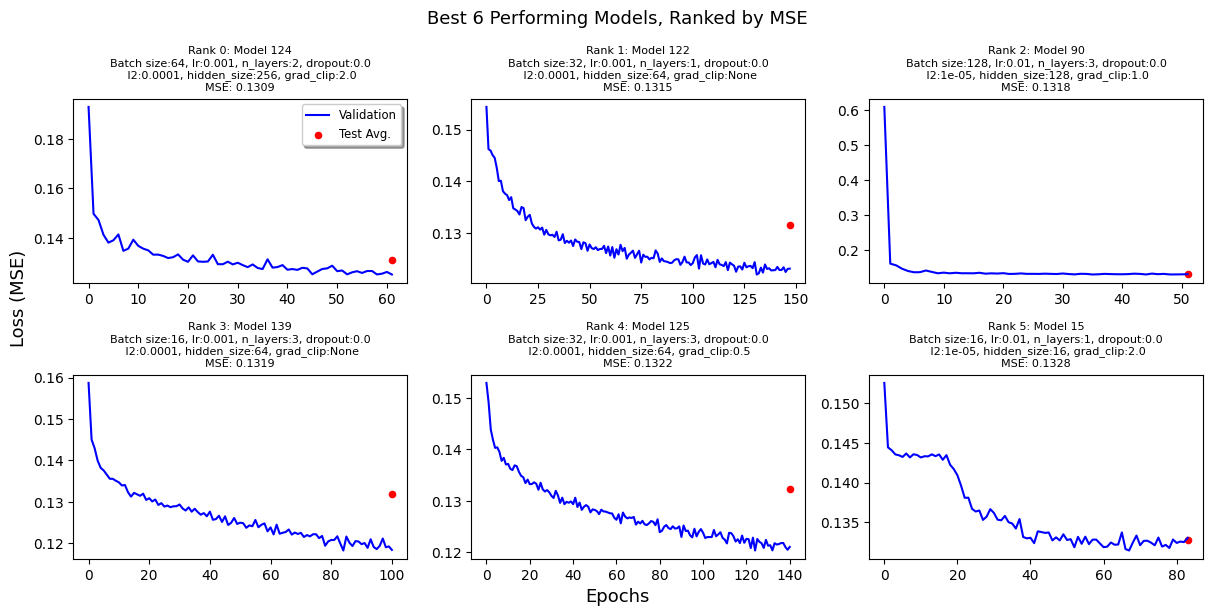

In [ ]:
best_hyperparameter_results(results_rnn, loss=loss, n_best=6)

In [ ]:
#visualize_all_hyperparameter_results(results_rnn, loss=loss)

In [ ]:
# Save full results to csv
mlp_hyperparam_testing['result_variance'] = [np.var(results_rnn[i][0]) for i in results_rnn]
rnn_hyperparam_testing['tuning_epochs'] = [results_rnn[i][3] for i in results_rnn]
rnn_hyperparam_testing[f'tuning_loss_{loss}'] = [results_rnn[i][1] for i in results_rnn]
rnn_hyperparam_testing.to_csv('./tuning/rnn_hyperparameter_tuning.csv')

In [ ]:
# Determine best hyperparameters based on loss
min_index = rnn_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_rnn_params = rnn_hyperparam_testing.iloc[min_index].to_dict()
print("Best RNN Parameters:")
for key in best_rnn_params:
    print(f"{key}: {best_rnn_params[key]}")

# Write these results to file
with open('./tuning/rnn_best_params.json', 'w') as file:
    best_rnn_params.pop('tuning_loss_MSE', None)
    best_rnn_params.pop('result_variance', None)
    best_rnn_params.pop('tuning_epochs', None)

    dump(best_rnn_params, file, indent=4)

Best RNN Parameters:
batch_size: 64.0
n_layers: 2.0
lr: 0.001
rnn_dropout: 0.5
weight_decay: 0.0001
grad_clip: 2.0
hidden_size: 256.0
tuning_epochs: 62.0
tuning_loss_MSE: 0.13089989469107693


## RNN Layer Experiment

Showing effect of the number of RNN layers on final model performance.

In [ ]:
# Initialize the model and move it to the appropriate device
layers = [1, 2, 5, 10, 20]
layer_losses = {layer: [] for layer in layers}

num_epochs = 25

# Get best hyperparameters from tuning
lr = best_rnn_params['lr']
grad_clip = best_rnn_params['grad_clip']
#batch_size = best_rnn_params_layer['batch_size']
weight_decay = best_rnn_params['weight_decay']
hidden_size = int(best_rnn_params['hidden_size'])
rnn_dropout = best_rnn_params['rnn_dropout']


# Run experiment
for rnn_layer in layers:

    # Initialize model
    input_size = test_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN(input_size=input_size, rnn_dropout=rnn_dropout, hidden_size=hidden_size, n_layers=rnn_layer).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_layer} layers)")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, test_dataloader, DEVICE, loss_fn='RMSE', grad_clip=grad_clip)
        avg_valid_loss = evaluate_model(RNN_model, valid_dataloader, DEVICE, loss_fn='RMSE')

        layer_losses[rnn_layer].append(avg_train_loss)
        #dropout_losses[rnn_dropout][1].append(avg_train_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Training RNN (20 layers): 100%|██████████| 25/25 [05:33<00:00, 13.34s/it, Train loss=0.373, Validation loss=0.379]


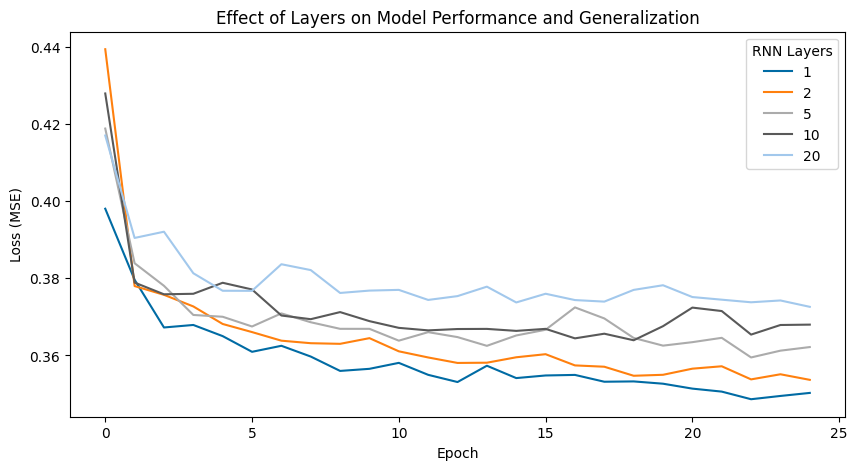

In [ ]:
# Plot loss over time
plt.figure(figsize=(10, 5))
plt.title(f'Effect of Layers on Model Performance and Generalization', fontsize=12)
#plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c']
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#A2C8EC',]
for i, layer in enumerate(layer_losses):
    #plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(layer_losses[layer], linestyle='solid', c=colors[i], label=layer)
#plt.plot(np.array([layer_losses[dl][1] for dl in layer_losses]).mean(axis=0), color='black')
plt.legend(title='RNN Layers', loc='upper right')

plt.show()